In [ ]:
!pip install wandb

In [ ]:
import random
import numpy as np
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [ ]:
# Enable GPU 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
# load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        # label is set to 1 when the pair of example is matched
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        # label is set to 0 when the pair of example are not matched 
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
print("number of pairs in training:", len(pairs_train))
print("number of pairs in testing:", len(pairs_test))

number of pairs in training: 120000
number of pairs in testing: 20000


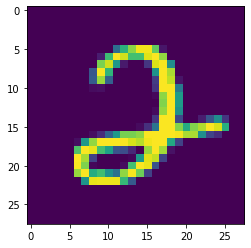

In [ ]:
plt.imshow(pairs_train[32][0])

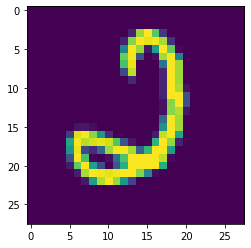

In [ ]:
plt.imshow(pairs_train[32][1])

In [ ]:
print("corresponding label:", labels_train[32])

corresponding label: 1


In [ ]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt( K.maximum( sum_square, K.epsilon() ) )

input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model (Functional)             (None, 128)          100480      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

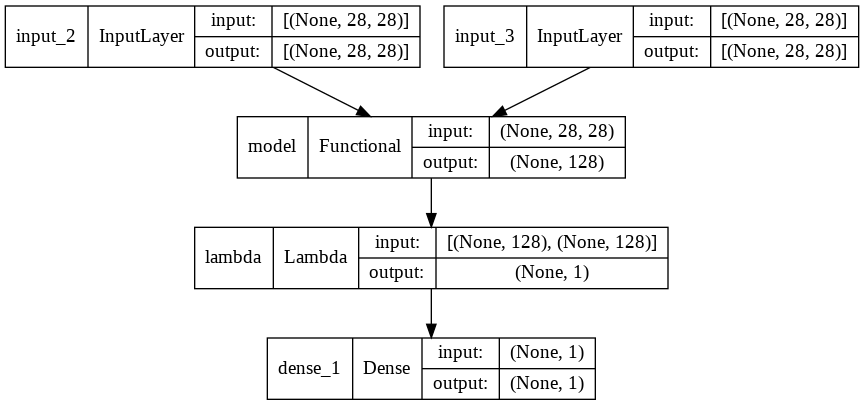

In [ ]:
# visualise the model to have a better look 
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
wandb.init(project="siamese")
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/10
7500/7500 [==============================] - 27s 3ms/step - loss: 0.4499 - accuracy: 0.7941
Epoch 2/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3460 - accuracy: 0.8551
Epoch 3/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3335 - accuracy: 0.8605
Epoch 4/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.3244 - accuracy: 0.8642
Epoch 5/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.2989 - accuracy: 0.8764
Epoch 6/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.2878 - accuracy: 0.8824
Epoch 7/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.2841 - accuracy: 0.8837
Epoch 8/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.2821 - accuracy: 0.8845
Epoch 9/10
7500/7500 [==============================] - 24s 3ms/step - loss: 0.2808 - accuracy: 0.8843
Epoch 10/10
7500/7500 [==============================] - 26s 3ms/step - l